# TP4
### Physique Numérique (PHY-3500)
### Par: Simon Gauthier, Laurent Émond, Thomas Charland
### Présenté à: Xavier Roy-Pomerleau et Antoine Allard
### Remis le: 14 avril 2025

In [47]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

### TP4.1 Intégration numérique de la dynamique épidémiologique SIS (50 points)

#### a)

On peut simplement solutionner analytiquement l'équation quadratique suivante:
$$
0=(R_0-1)i-R_0i^2
$$
On trouve donc que les solutions, ou états stationnaires, sont:
$$
i^*_1=0\qquad\qquad i^*_2=1-\frac{1}{R_0}
$$
Puisque $i^*_{1,2}$ doit être dans l'intervalle [0,1], cela impose les valeurs $R_0\ge1$.

#### b)

En utilisant $\frac{di}{d\tau}=i'$, on peut placer dans la forme de Bernouilli, soit $i'+p(\tau)i=q(\tau)i^n$:
$$
    i'+(1-R_0)i=(-R_0)i^2
$$
où $p(\tau)=1-R_0$, $q(\tau)=(-R_0)$ et $n=2$.

On peut alors diviser par $i^{-n}=i^{-2}$:
$$
    i^{-2}i'+(1-R_0)i^{-1}=-R_0
$$
On utilise ensuite la substitution $v=i^{1-n}=i^{-1}$. 
$$
    v^2i'+(1-R_0)v=-R_0
$$
On doit également trouver $i'$ en fonction de $v$. On peut dériver implicitement notre substitution et isoler $i'$, soit $i'=-i^2v'=-\frac{1}{v^2}v'$. On remplace:
$$
-v'+(1-R_0)v=-R_0
$$
On divise par $-1$:
$$
v'+(R_0-1)v=R_0
$$
Cette EDO en $v$ est linéaire, on peut donc la résoudre à l'aide de la méthode du facteur d'intégration $\mu(\tau)$. On multiplie donc l'équation par $\mu(\tau)$:
$$
v'\mu(\tau)+(R_0-1)v\mu(\tau)=R_0\mu(\tau)
$$
On assume pour l'instant la condition $\mu(\tau)(R_0-1)=\mu'(\tau)$. On a donc:
$$
v'\mu(\tau)+v\mu'(\tau)=R_0\mu(\tau)
$$
On remarque que le côté gauche est simplement la dérivée du produit $v\mu(\tau)$. On a donc:
$$
(v\mu(\tau))'=R_0\mu(\tau)
$$
On intègre alors des deux côtés par rapport à $\tau$ et on obtient:
$$
v\mu(\tau)+C=\int R_0\mu(\tau) d\tau
$$
où $C$ est notre constante d'intégration. On isole $v$:
$$
v=\frac{\int R_0\mu(\tau) d\tau - C}{\mu(\tau)}
$$
Maintenant, sachant que $\frac{\mu'(\tau)}{\mu(\tau)}=R_0-1$, on trouve que $\mu(\tau)=e^{\int (R_0-1) d\tau + k}=Ke^{(R_0-1)\tau}$ où $K=e^k$ est une constante d'intégration. On a donc:
$$
v=\frac{K\int R_0e^{(R_0-1)\tau} d\tau - \frac{C}{k}}{Ke^{(R_0-1)\tau}}
$$
On définit $c_1=\frac{c}{K}$ pour avoir:
$$
\begin{align*}
v&=\frac{\int R_0e^{(R_0-1)\tau} d\tau - c_1}{e^{(R_0-1)\tau}}\\
&=\frac{\frac{R_0}{R_0-1}e^{(R_0-1)\tau}+c_2-c_1}{e^{(R_0-1)\tau}}\\
&=\frac{\frac{R_0}{R_0-1}e^{(R_0-1)\tau}+C}{e^{(R_0-1)\tau}}
\end{align*}
$$
où $C=c_2-c_1$ est une constante. On peut alors exprimer $v$ en fonction de $i$ et isoler $i$:
$$
i=\frac{1}{v}=\frac{e^{(R_0-1)\tau}}{\frac{R_0}{R_0-1}e^{(R_0-1)\tau}+C}
$$
On peut ensuite utiliser une condition initiale $i(0)=i_0$ pour obtenir:
$$
i_0=\frac{e^{(R_0-1)0}}{\frac{R_0}{R_0-1}e^{(R_0-1)0}+C}=\frac{1}{\frac{R_0}{R_0-1}+C}
$$
On a donc:
$$
C= \frac{R_0-1-R_0i_0}{i_0(R_0-1)}
$$
On a donc:
$$
i(\tau)=\frac{e^{(R_0-1)\tau}}{\frac{R_0}{R_0-1}e^{(R_0-1)\tau}+\frac{R_0-1-R_0i_0}{i_0(R_0-1)}}=\frac{i_0(R_0-1)e^{(R_0-1)\tau}}{i_0R_0e^{(R_0-1)\tau}+R_0-1-i_0R_0}
$$
pour $\tau>0$. Cela impose la branche positive de la solution particulière, soit $i>0$.

On peut tracer cette solution pour une condition initiale $i_0=0.5$ et une valeur $R_0=1.5$:

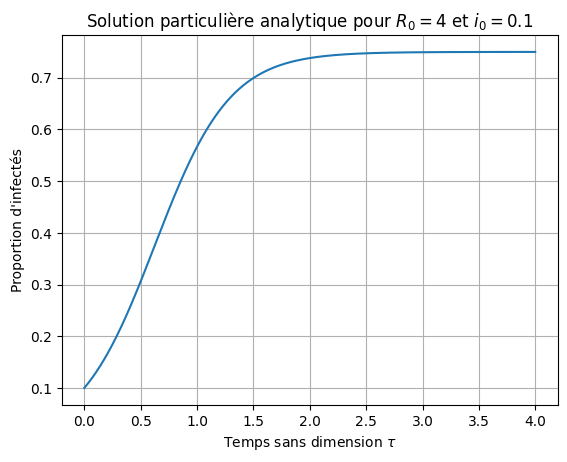

In [48]:
def analytical(times, R0, i0):
    """ Solution particulière analytique du modèle SIR."""
    return (i0*(R0-1)*np.exp((R0-1)*times))/(i0*R0*np.exp((R0-1)*times)+R0-1-i0*R0)


R0 = 4 # nombre de personnes infectées par une personne infectée
i0 = 0.1 # proportion d'infectés au temps t=0

times = np.linspace(0, 4, 1000)

plt.plot(times, analytical(times, R0, i0))
plt.title(fr"Solution particulière analytique pour $R_0={R0}$ et $i_0={i0}$")
plt.xlabel(r"Temps sans dimension $\tau$")
plt.ylabel(r"Proportion d'infectés")
plt.grid()
plt.show()

#### c)


In [54]:
def infection_rate(i, R0):
    return (R0-1)*i-R0*i**2

def euler(T, h, R0, i0):
    """ Méthode d'Euler pour la résolution de l'ODE"""
    i = np.zeros(T+1)
    i[0] = i0
    for j in range(1, T+1):
        i[j] = i[j-1] + h*infection_rate(i[j-1], R0)
    return h*np.arange(0, T+1), i

def rk2(T, h, R0, i0):
    """ Méthode de Runge-Kutta d'ordre 2 pour la résolution de l'ODE"""
    i = np.zeros(T+1)
    i[0] = i0
    for j in range(1, T+1):
        k1 = h*infection_rate(i[j-1], R0)
        k2 = h*infection_rate(i[j-1] + 0.5*k1, R0)
        i[j] = i[j-1] + k2
    return h*np.arange(0, T+1), i

def rk4(T, h, R0, i0):
    """ Méthode de Runge-Kutta d'ordre 4 pour la résolution de l'ODE"""
    i = np.zeros(T+1)
    i[0] = i0
    for j in range(1, T+1):
        k1 = h*infection_rate(i[j-1], R0)
        k2 = h*infection_rate(i[j-1] + 0.5*k1, R0)
        k3 = h*infection_rate(i[j-1] + 0.5*k2, R0)
        k4 = h*infection_rate(i[j-1] + k3, R0)
        i[j] = i[j-1] + (k1 + 2*k2 + 2*k3 + k4)/6
    return h*np.arange(0, T+1), i

#### d)


In [ ]:
R0i0_pairs = [(1.5, 0.1), (1.5, 0.9), (2, 0.1), (2, 0.9), (3, 0.1), (3, 0.9)]
deltas = [1e-6, 1e-7, 1e-8, 1e-9]


def error(f, T, h, R0, i0):
    times, i = f(T, h, R0, i0)
    i_analytical = analytical(times, R0, i0)
    error = np.sqrt(1/(len(i)+1)*np.sum((i-i_analytical)**2))
    return error

def golden_ratio_method(f, h1, h4, T, R0, i0, delta, max_iter=100):
    # golden ratio method to return the h value that minimizes (error(f) - delta)
    # break and return h when abs(error(f) - delta) < 0.01*delta
    # f: function to minimize (euler, rk2, rk4)
    # h1: lower bound of the search interval
    # h4: upper bound of the search interval
    # T: number of time steps

    z = (1 + np.sqrt(5)) / 2 # nombre d'or
    h2 = h4 - (h4-h1)/z
    h3 = h1 + (h4-h1)/z

    for _ in range(max_iter):
        val_to_minimize_2 = error(f, T, h2, R0, i0) - delta
        val_to_minimize_3 = error(f, T, h3, R0, i0) - delta

        print(abs(val_to_minimize_2), abs(val_to_minimize_3), 0.01*delta, h2)

        if abs(val_to_minimize_2) < 0.01*delta:
            return h2
        elif abs(val_to_minimize_3) < 0.01*delta:
            return h3

        if val_to_minimize_2 < val_to_minimize_3:
            h4 = h3
            h3 = h2
            h2 = h4 - (h4-h1)/z
        else:
            h1 = h2
            h2 = h3
            h3 = h1 + (h4-h1)/z
    raise ValueError("La méthode de la section dorée n'a pas convergé dans le nombre d'itérations maximal autorisé.")

R0, i0 = R0i0_pairs[0]
delta = deltas[0]

h1 = 1e-10
h4 = 1

h = golden_ratio_method(euler, h1, h4, 1000, R0, i0, delta)

In [70]:
for h in np.logspace(-10, 0, 11):
    print(error(euler, 3, h, R0, i0), error(rk2, 3, h, R0, i0), error(rk4, 3, h, R0, i0))

2.6331251014325257e-17 2.6331251014325257e-17 2.6331251014325257e-17
2.1499376424746292e-17 2.1499376424746292e-17 2.1499376424746292e-17
1.642041997679149e-17 1.642041997679149e-17 1.642041997679149e-17
6.798699777552591e-17 1.5202354861220296e-17 1.5202354861220296e-17
5.85693287359983e-15 1.3877787807814457e-17 1.3877787807814457e-17
5.856616691614462e-13 1.962615573354719e-17 1.962615573354719e-17
5.856499252579838e-11 1.4220500840710912e-16 1.8619006149354548e-17
5.855407527022475e-09 1.337105688386613e-13 1.5202354861220296e-17
5.844224122275278e-07 1.2915472231447105e-10 5.17699151110882e-16
5.7057415366888026e-05 8.398732577619602e-08 4.958297140418068e-11
0.0025664264146309213 0.00019388726079405983 3.1972597007156456e-06


Afin de déterminer les bornes pour les valeurs de départ de $h$, il est possible de calculer l'erreur pour quelques valeurs à l'aide d'une vecteur dispersé logarithmiquement entre $h=0.1$ et $h=10^{-5}$. On calcule ainsi seulement 10 valeurs et il serait possible d'interpoler des valeurs à partir de cette courbe. On trace ainsi:

2.004415017402349 3.0021734978559365 5.008059952867413


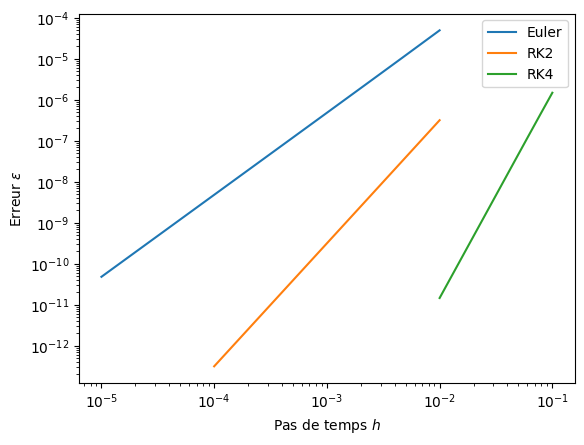

In [51]:
log_h_space_euler = np.logspace(-5, -2, 10)
log_h_space_rk2 = np.logspace(-4, -2, 10)
log_h_space_rk4 = np.logspace(-2, -1, 10)

errors_euler = np.array([error(euler, T, h, R0, i0) for h in log_h_space_euler]) # erreur pour chacune des valeurs de T
errors_rk2 = np.array([error(rk2, T, h, R0, i0) for h in log_h_space_rk2]) # erreur pour chacune des valeurs de T
errors_rk4 = np.array([error(rk4, T, h, R0, i0) for h in log_h_space_rk4]) # erreur pour chacune des valeurs de T


T = 3

def slope(x, y):
    """ Calcul de la pente entre deux points """
    return (y[-1]-y[0])/(x[-1]-x[0])

slope_euler = slope(np.log(log_h_space_euler), np.log(errors_euler))
slope_rk2 = slope(np.log(log_h_space_rk2), np.log(errors_rk2))
slope_rk4 = slope(np.log(log_h_space_rk4), np.log(errors_rk4))

print(slope_euler, slope_rk2, slope_rk4)


plt.plot(log_h_space_euler, errors_euler, label="Euler")
plt.plot(log_h_space_rk2, errors_rk2, label="RK2")
plt.plot(log_h_space_rk4, errors_rk4, label="RK4")
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"Pas de temps $h$")
plt.ylabel(r"Erreur $\epsilon$")
plt.legend()
plt.show()

On remarque qu'en utilisant des axes log-log, les courbes sont linéaires (excepté RK4 qui atteint la précision machine à partir de h=0.001). Il sera donc facile de trouver les valeurs de départ pour $h$. En effet, on peut faire une interpolation linéaire et choisir un petit intervalle autour de la valeur de $\epsilon$ désirée, disons entre $0.5\hat\epsilon$ et $1.5\hat\epsilon$ où $\hat\epsilon$ est la valeur interpolée à partir des quelques points d'erreurs calculés précemment. Il est important de faire l'interpolation en log et de remettre en linéaire les bornes de $h$ trouvées avant de la passer à la méthode du ratio doré:

In [52]:
def estimate_h1_h4(method, lower_h_exp, higher_h_exp, T, R0, i0, delta):
    log_h_space = np.logspace(lower_h_exp, higher_h_exp, 10)
    errors = np.array([error(method, T, h, R0, i0) for h in log_h_space])

    h1 = np.interp(10**(0.5*delta), 10**errors, 10**log_h_space)
    h4 = np.interp(10**(1.5*delta), 10**errors, 10**log_h_space)

    slope = (np.log10(h4) - np.log10(h1)) / (np.log10(10**(1.5*delta)) - np.log10(10**(0.5*delta)))

    return np.log10(h1), np.log10(h4)

Il est maintenant possible d'itérer sur les valeurs de $\delta$ ainsi que sur les couples $(R_0,I_0)$ pour chacune des trois méthodes:

In [ ]:
i = 0

# euler
for delta in deltas:
    for R0, i0 in R0i0_pairs:
        h1, h4 = 1, 1e-6
        h = golden_ratio_method(euler, h1, h4, T, R0, i0, delta)
        print(f"Euler: {h}")

#### e)


### TP4.2 Simulation Monte-Carlo de la dynamique SIS (50 points)

#### a)


#### b)


#### c)


#### d)